## Setup

In [2]:
# imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from kpca.utils import *
from kpca.kernel_pca import KernelPCA
from kpca.data import Loader, mnist

# ipython
%matplotlib inline 
%load_ext autoreload
%autoreload 2

# cuda
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

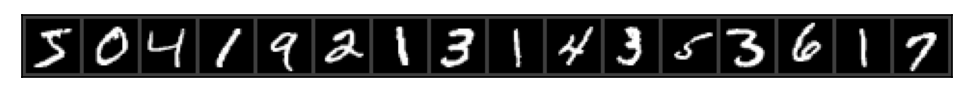

In [4]:
x1,l1,x2,l2,x3,l3 = mnist('cuda')[:6]
x = torch.cat([x1,x2,x3]) # concat train, val, test
# x = x[:,:,4:-4,4:-4].contiguous() # crop borders
x = tovec(x) # convert to vec
x /= x.std() # normalize
show_grid(toim(x)[:16],nrow=16)

## Train

In [19]:
# seed 
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)

In [20]:
d = 3
loader = Loader(x,batch_size=64).__iter__()
net = KernelPCA(m=784, n=800, kernel='cos', d=1, lam=1e-3, device='cuda')
info = None

In [21]:
# warmup period
info = net.train(loader,etaq=0.0,etaw=0.01,etal=.1,n_iter=1000,print_iter=10)

0/1000: e=63261.3398, t=0.0237
100/1000: e=4346.4810, t=1.4942
200/1000: e=107933.8203, t=3.0019
300/1000: e=365611.6562, t=4.5799
400/1000: e=823471.4375, t=5.8888
500/1000: e=1577861.8750, t=7.2906
600/1000: e=2449830.5000, t=8.5551
700/1000: e=3012136.0000, t=10.1629
800/1000: e=3224032.2500, t=11.7252
900/1000: e=3082891.2500, t=13.1520


In [22]:
# training 
net.d = d
info = net.train(loader,etaq=0.0,etaw=.001,etal=0.01,n_iter=5000,print_iter=10,info=info)

0/5000: e=3704891.5000, t=0.0183
500/5000: e=8374.2783, t=7.8302
1000/5000: e=-6670.5005, t=15.1696
1500/5000: e=-2021.2059, t=22.4460
2000/5000: e=735.2476, t=30.3495
2500/5000: e=284.4348, t=39.1118
3000/5000: e=2490.7200, t=47.3192
3500/5000: e=1372.8755, t=54.9526
4000/5000: e=3559.8220, t=62.8605
4500/5000: e=2540.9985, t=70.3897


In [23]:
info = net.train(loader,etaq=0.0,etaw=.0001,etal=0.001,n_iter=5000,print_iter=10,info=info)

0/5000: e=2601.2141, t=0.0201
500/5000: e=2606.5730, t=6.7782
1000/5000: e=2846.3489, t=14.0778
1500/5000: e=2725.2996, t=21.3845
2000/5000: e=4092.8218, t=28.8690
2500/5000: e=3420.9417, t=36.0147
3000/5000: e=2753.8604, t=43.1036
3500/5000: e=4128.5225, t=50.4836
4000/5000: e=4432.9756, t=57.3229
4500/5000: e=6298.7969, t=64.8276


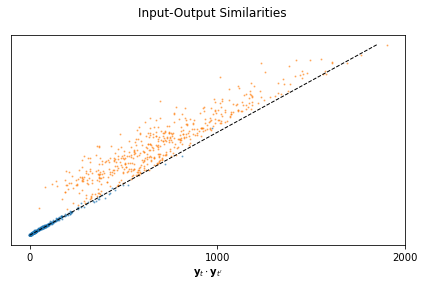

In [24]:
t = 500

y = net(x)
yy = y[:t] @ y[:t].t()
fxx = net.f(x[:t],x[:t])

ixs = torch.randperm(len(offdiag(fxx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(fxx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(fxx).detach().cpu().numpy(), s=1, label=r"$t = t'$", alpha=0.5)
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([0,1000,2000])
plt.yticks([])
plt.xlabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")

plt.suptitle('Input-Output Similarities')
plt.tight_layout()

## Save Figures

In [25]:
MODEL_PATH = './trained-nets/mnist-d_{}-784.pt'.format(d)
torch.save(net.state_dict(), MODEL_PATH)

## Training evaluation

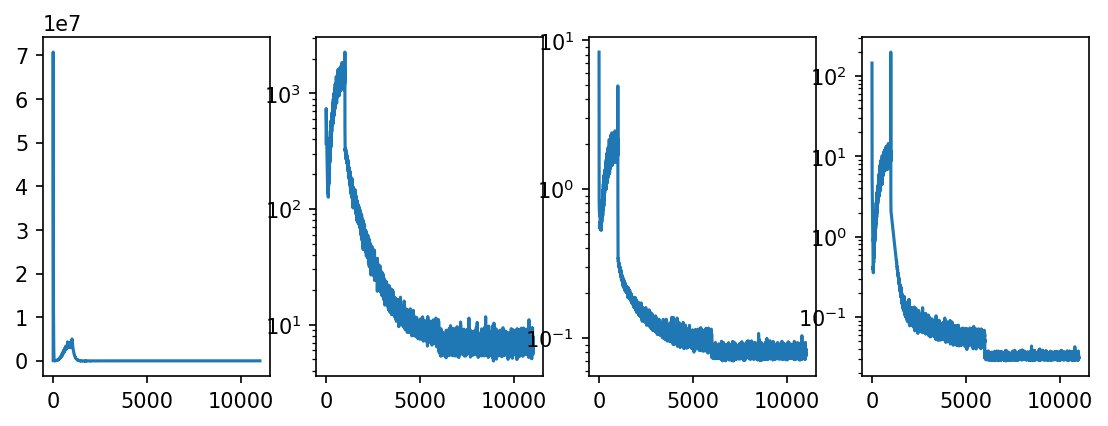

In [26]:
plt.figure(figsize=(9,3),dpi=150)
plt.subplot(141)
plt.plot(info['es'])

plt.subplot(142)
plt.plot(info['gqs'])
plt.yscale('log')

plt.subplot(143)
plt.plot(info['gws'])
plt.yscale('log')

plt.subplot(144)
plt.plot(info['gls'])
plt.yscale('log')

## Visualize the results

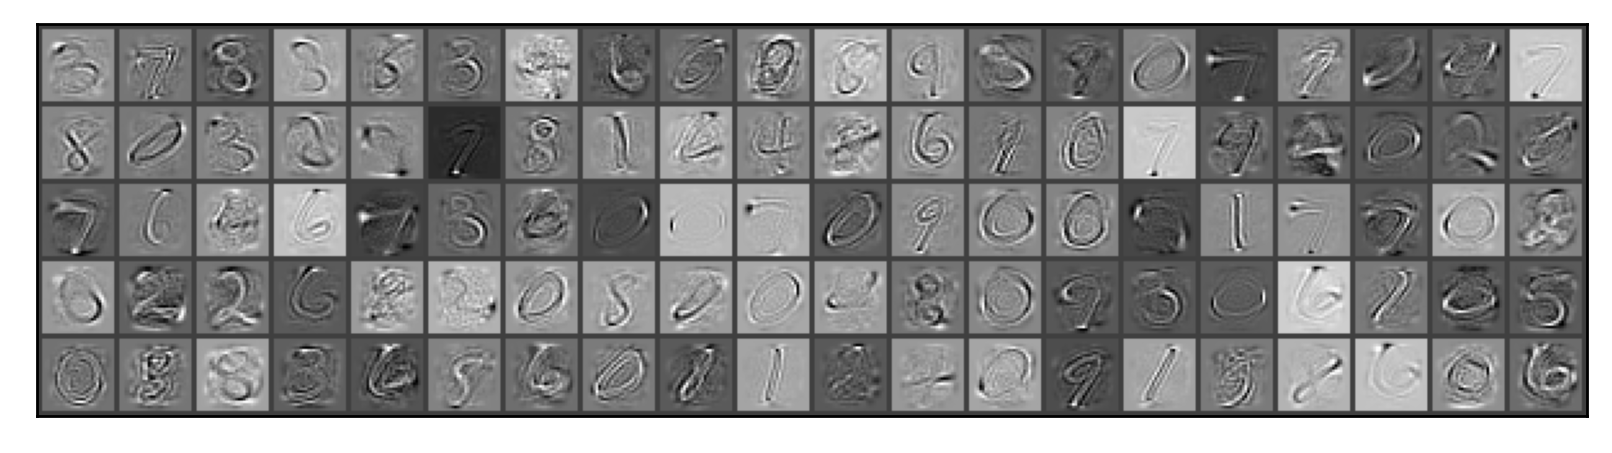

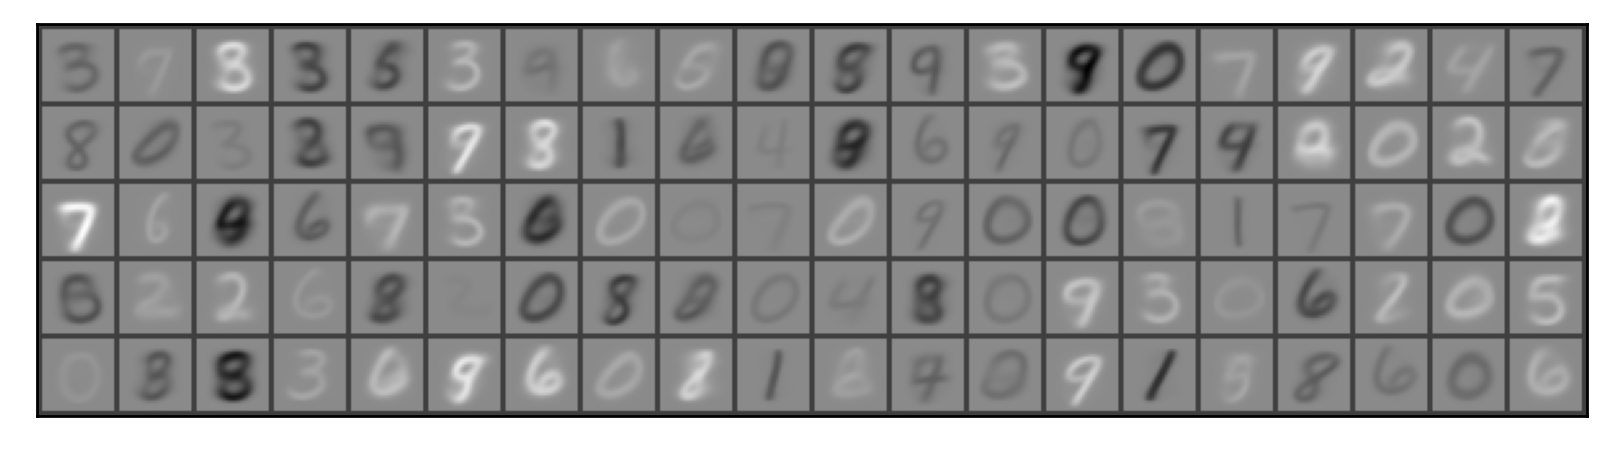

In [27]:
y = net(x)
wf = sta(x,y,1e-1)
show_grid(toim(wf[:100]),nrow=20, dpi=250, norm_every=True)
show_grid(toim(net.w[:100]),nrow=20,dpi=250, norm_every=False)